# Does it work?

## Looking at game ratings and net rating

First, let's examine the relationship between player impact and team net rating.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from nbaspa.data.endpoints.parameters import ParameterValues, SEASONS
from nbaspa.data.factory import NBADataFactory

In [2]:
calls = []
for season in SEASONS:
    for team in ParameterValues().TeamID:
        if team == 0:
            continue
        calls.append(("TeamLineups", {"TeamID": team, "Season": season, "output_dir": os.path.join(os.environ["DATA_DIR"], season)}))

In [3]:
loader = NBADataFactory(calls=calls)
_ = loader.load()

|████████████████████████████████████████| 480/480 [100%] in 3.8s (127.02/s)


In [4]:
overall = loader.get_data("Overall")
avg_rating = np.average(overall["E_NET_RATING"].values)

In [5]:
ratings = pd.concat(
    (
        pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        for fpath in Path(os.environ["DATA_DIR"]).glob("*/game-impact/data_*.csv")
    ),
    ignore_index=True
)
ratings["SEASON"] = (
    ratings["GAME_ID"].str[2]
    + "0"
    + ratings["GAME_ID"].str[3:5]
    + "-"
    + (ratings["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)

In [6]:
agg = ratings.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])[["IMPACT", "IMPACT+", "CLUTCH_IMPACT", "CLUTCH_EVENTS"]].sum()
agg["NON_CLUTCH_IMPACT"] = agg["IMPACT"] - agg["CLUTCH_IMPACT"]
agg.reset_index(inplace=True)

In [7]:
bin_result, edges = pd.qcut(overall["E_NET_RATING"], q=5, retbins=True)
edges = np.round(edges, 1)
bin_result.cat.rename_categories([f"{edges[i-1]} to {edges[i]}" for i in range(1, len(edges))], inplace=True)

In [8]:
overall["RATING_BIN"] = bin_result
agg["RATING_BIN"] = pd.merge(agg, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

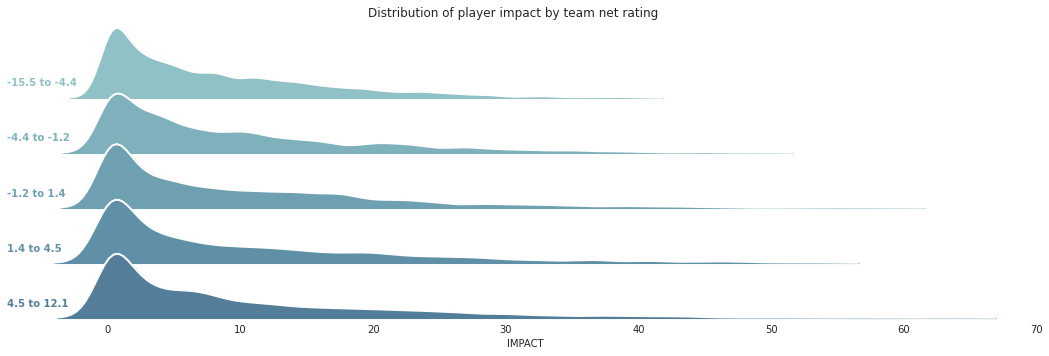

In [9]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    facet = sns.FacetGrid(agg, row="RATING_BIN", aspect=15, hue="RATING_BIN", height=1, palette=sns.cubehelix_palette(10, rot=-.25, light=.7))
    facet.map(sns.kdeplot, "IMPACT", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    facet.map(sns.kdeplot, "IMPACT", clip_on=False, color="w", lw=2, bw_adjust=.5)
    facet.map(label, "IMPACT")
    facet.fig.subplots_adjust(hspace=-.25)
    facet.set_titles("")
    facet.set(yticks=[])
    facet.despine(bottom=True, left=True)
    
    facet.fig.suptitle("Distribution of player impact by team net rating")

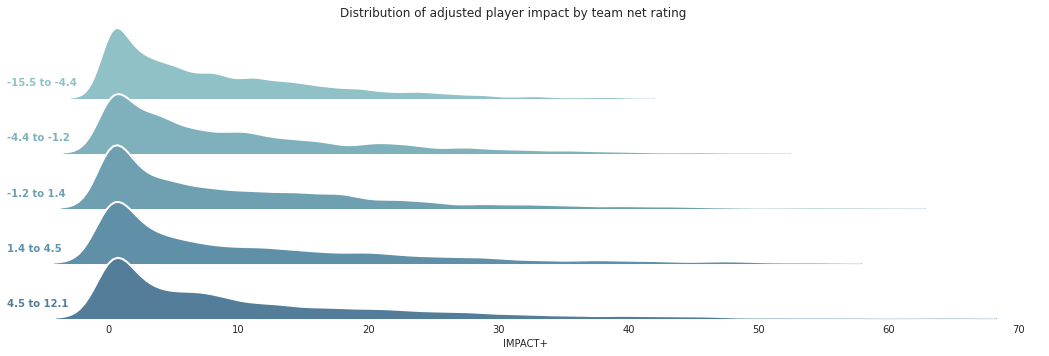

In [10]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    facet = sns.FacetGrid(agg, row="RATING_BIN", aspect=15, hue="RATING_BIN", height=1, palette=sns.cubehelix_palette(10, rot=-.25, light=.7))
    facet.map(sns.kdeplot, "IMPACT+", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    facet.map(sns.kdeplot, "IMPACT+", clip_on=False, color="w", lw=2, bw_adjust=.5)
    facet.map(label, "IMPACT+")
    facet.fig.subplots_adjust(hspace=-.25)
    facet.set_titles("")
    facet.set(yticks=[])
    facet.despine(bottom=True, left=True)
    
    facet.fig.suptitle("Distribution of adjusted player impact by team net rating")

- Player-level ratings across team bins overlap and have similar means. Variance on better teams is lower, with "good" teams having the highest ceiling.

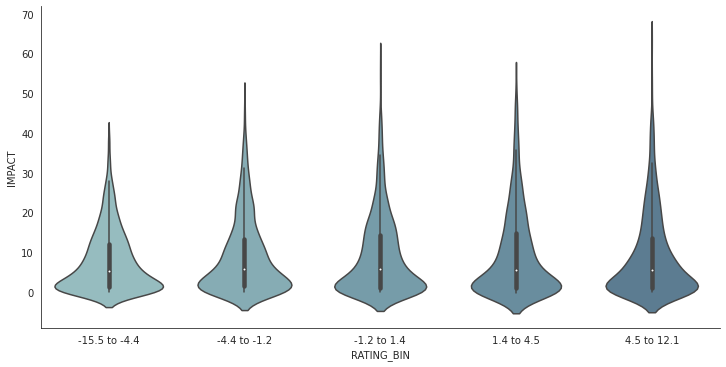

In [11]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

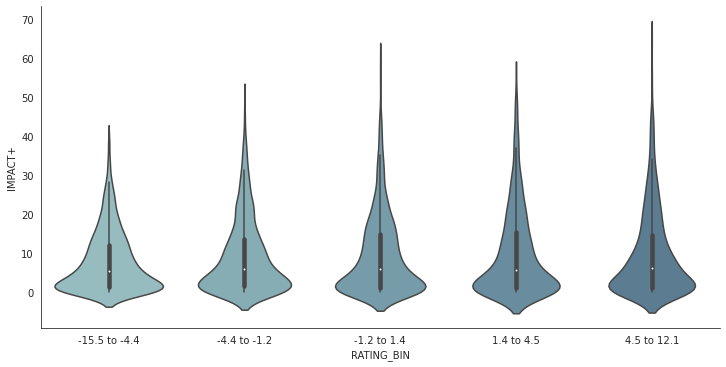

In [12]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT+",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

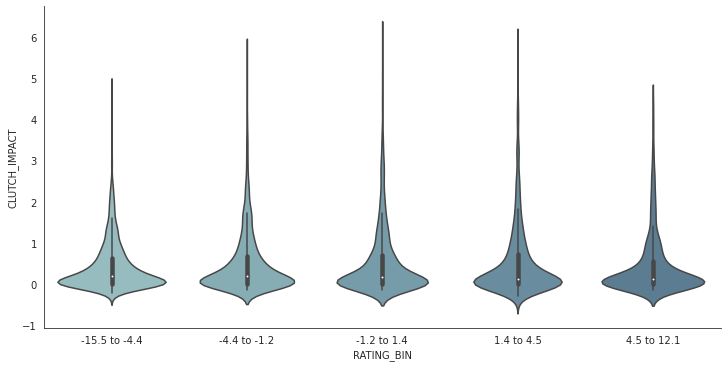

In [13]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="CLUTCH_IMPACT",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

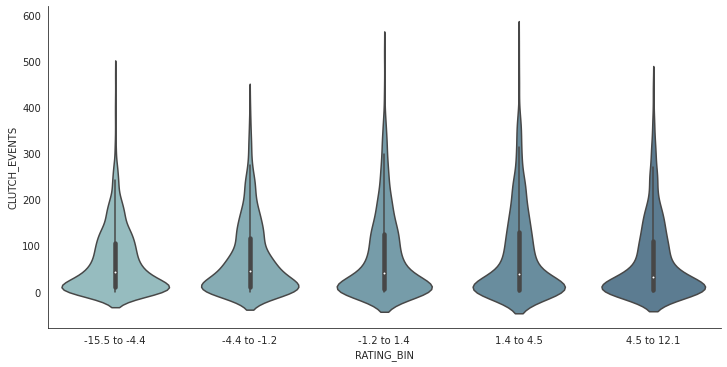

In [14]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="CLUTCH_EVENTS",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

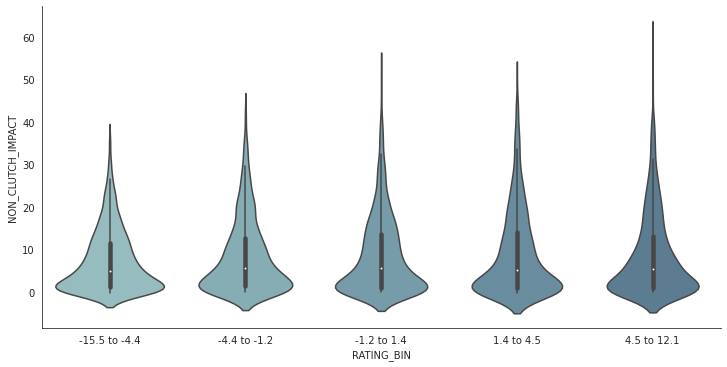

In [15]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="NON_CLUTCH_IMPACT",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

# TEAM-SEASON Aggregation

- Hypothesis: Mediocre teams will have high average impact ratings because they are in more close games

In [16]:
agg_team = ratings.groupby(["TEAM_ID", "SEASON"])[["IMPACT", "IMPACT+", "CLUTCH_IMPACT", "CLUTCH_EVENTS"]].sum()
agg_team["NON_CLUTCH_IMPACT"] = agg_team["IMPACT"] - agg_team["CLUTCH_IMPACT"]
agg_team.reset_index(inplace=True)
agg_team["RATING_BIN"] = pd.merge(agg_team, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

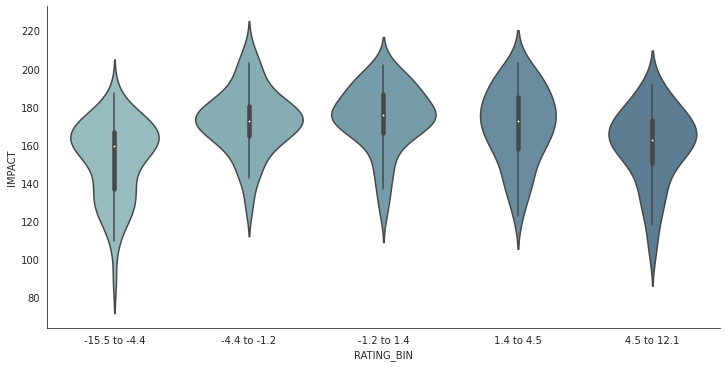

In [17]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

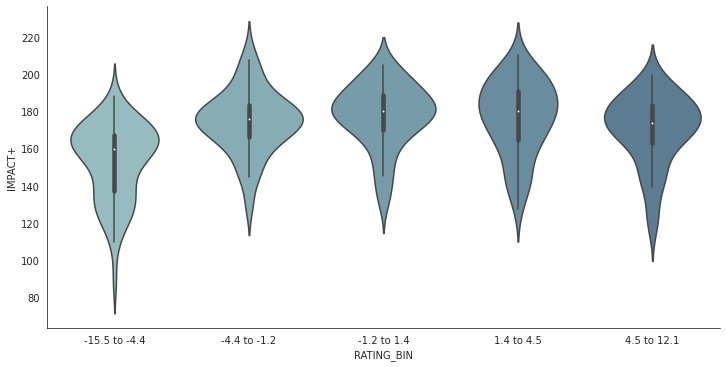

In [18]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT+",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

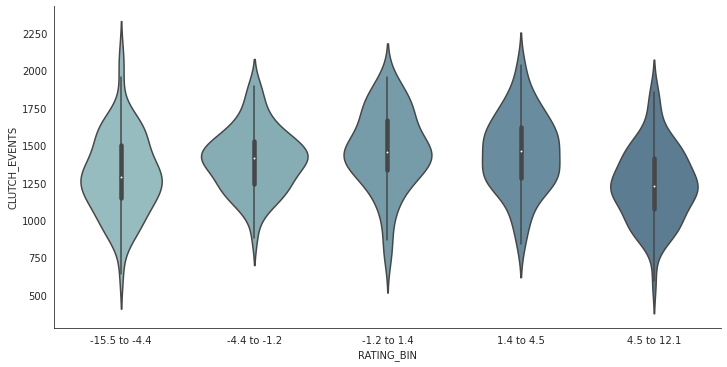

In [19]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="CLUTCH_EVENTS",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

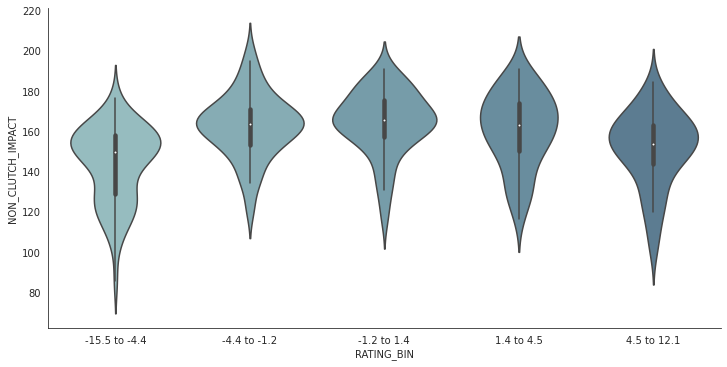

In [20]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="NON_CLUTCH_IMPACT",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )